<a href="https://colab.research.google.com/github/tom-mcilwain/STATS202-DataMining-FinalProject/blob/main/STATS_202_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras


In [ ]:
# Defining helpful methods
def time_to_idx(time, day):
  day_idx = 5040
  idx = int(int(time[6:]) / 5) + (12 * int(time[3:5])) + (12 * 60 * (int(time[0:2]) - 6)) + (day_idx * day)
  return int(idx)

def next_time(prev_time):
  next_time = prev_time.copy()
  if prev_time[3] < 55:
    next_time[3] += 5
  elif prev_time[3] == 55:
    next_time[3] = 0
    next_time[2] += 1
  if next_time[2] == 60:
    next_time[2] = 0
    next_time[1] += 1
  if next_time[1] == 13:
    next_time[1] = 6
    next_time[0] += 1
  return next_time

def time_to_str(time):
  return f'{time[0]:01}-{time[1]:02}:{time[2]:02}:{time[3]:02}'

In [ ]:
# Loading data
train_data = pd.read_csv('/content/drive/My Drive/train_data.csv')
train_data.head()

,symbol,open,high,low,close,average,time,day
0,B,101.72,101.72,101.72,101.72,101.72,06:00:00,0
1,B,101.72,101.72,101.72,101.72,101.72,06:00:05,0
2,B,101.72,101.72,101.72,101.72,101.72,06:00:10,0
3,B,101.72,101.72,101.72,101.72,101.72,06:00:15,0
4,B,101.72,101.72,101.72,101.72,101.72,06:00:20,0


In [ ]:
# Preprocessing
columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

data = pd.DataFrame(np.zeros((time_to_idx('06:00:00', 87), len(columns))), columns=columns)

for i in tqdm(range(train_data.shape[0])):
  row = train_data.iloc[i,:]
  t = row['time']
  d = row['day']
  if t == t and d == d:
    new_idx = time_to_idx(t, d)
    data[row['symbol']][new_idx] = row['open']
data.to_csv('/content/drive/My Drive/full_data.csv')

100%|██████████| 4330254/4330254 [2:04:24<00:00, 580.11it/s]


done


In [ ]:
# Loading in newly formatted data
data = pd.read_csv('/content/drive/My Drive/full_data.csv', index_col=0)

In [ ]:
# Changing missing data to random walk
warnings.filterwarnings("ignore")
means = data.mean(axis=0)
if np.where(data.iloc[0,:] == 0)[0] != []:
  loc = np.where(data.iloc[0,:] == 0)
  data.iloc[0, loc[0]] = means[loc[0]]
for i in tqdm(range(data.shape[0])):
  loc = np.where(data.iloc[i,:] == 0)
  move = np.random.choice([-0.001, 0.001], 1)
  data.iloc[i,loc[0]] = data.iloc[i-1,loc[0]] + move
data.head()

100%|██████████| 442794/442794 [08:45<00:00, 842.00it/s]


,A,B,C,D,E,F,G,H,I,J
0,136.01567,104.599024,96.116404,228.246553,120.658038,160.186072,173.319172,86.146967,173.129421,168.79585
1,136.01667,104.600024,96.117404,228.247553,120.659038,160.187072,173.320172,86.147967,173.130421,168.79685
2,136.01767,104.601024,96.118404,228.248553,120.660038,160.188072,173.321172,86.148967,173.131421,168.79785
3,136.01867,104.602024,96.119404,228.249553,120.661038,160.189072,173.322172,86.149967,173.132421,168.79885
4,136.01767,104.601024,96.118404,228.248553,120.660038,160.188072,173.321172,86.148967,173.131421,168.79785


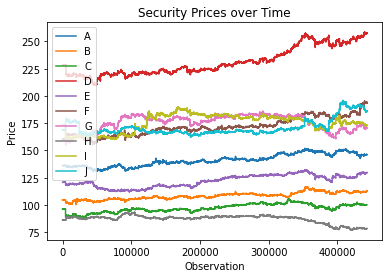

In [ ]:
# Visualizing opening prices for each ticker over time
data.plot()
plt.title('Security Prices over Time')
plt.xlabel('Observation')
plt.ylabel('Price')
print()

In [ ]:
# Adding day, hour, minute, and second features to the dataset
time = [0, 6, 0, 0]
times = pd.DataFrame(np.zeros(shape=(data.shape[0], 4)), columns=['day', 'hour', 'minute', 'second'])
for i in tqdm(range(data.shape[0])):
  times.iloc[i,:] = time
  time = next_time(time)
  
data['day'] = times.iloc[:,0]
data['hour'] = times.iloc[:,1]
data['minute'] = times.iloc[:,2]
data['second'] = times.iloc[:,3]

data.head()

100%|██████████| 442794/442794 [00:39<00:00, 11271.00it/s]


,A,B,C,D,E,F,G,H,I,J,day,hour,minute,second
0,136.01567,104.599024,96.116404,228.246553,120.658038,160.186072,173.319172,86.146967,173.129421,168.79585,0.0,6.0,0.0,0.0
1,136.01667,104.600024,96.117404,228.247553,120.659038,160.187072,173.320172,86.147967,173.130421,168.79685,0.0,6.0,0.0,5.0
2,136.01767,104.601024,96.118404,228.248553,120.660038,160.188072,173.321172,86.148967,173.131421,168.79785,0.0,6.0,0.0,10.0
3,136.01867,104.602024,96.119404,228.249553,120.661038,160.189072,173.322172,86.149967,173.132421,168.79885,0.0,6.0,0.0,15.0
4,136.01767,104.601024,96.118404,228.248553,120.660038,160.188072,173.321172,86.148967,173.131421,168.79785,0.0,6.0,0.0,20.0


### Train Test Split

In [ ]:
# Loading final data
data = pd.read_csv('/content/drive/My Drive/data.csv', index_col=0)

In [ ]:
# Train-test split
train_size = 0.8
train_idx = int(train_size * data.shape[0])
targets = data.shift(1, axis=0).iloc[:,:-4]

train_data = tf.convert_to_tensor(np.asarray(data.iloc[:train_idx,:]).astype('float32'))[1:]
train_targets = tf.convert_to_tensor(np.asarray(targets.iloc[:train_idx,:]).astype('float32'))[1:]

test_data = tf.convert_to_tensor(np.asarray(data.iloc[train_idx:,:]).astype('float32'))[1:]
test_targets = tf.convert_to_tensor(np.asarray(targets.iloc[train_idx:,:]).astype('float32'))[1:]

# **LSTM**

In [ ]:
# Generating dataset with lag variables

n_input = 12 # number of lag variables
generator = TimeseriesGenerator(train_data, train_targets, n_input, batch_size=1)

In [ ]:
# Implementing the LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 14)))
model.add(Dense(10))
model.compile(optimizer='adam', loss='mse')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100)               46000     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1010      
Total params: 47,010
Trainable params: 47,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting and saving the model
model.fit_generator(generator, epochs=1)
model.save('/content/drive/My Drive/lstm_model_2')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


 99346/354174 [=======>......................] - ETA: 1:37:00 - loss: 2321264.2500

KeyboardInterrupt: ignored

# Loading model

In [ ]:
# Loading model
model = keras.models.load_model('/content/drive/My Drive/lstm_model_2')

In [ ]:
# Getting predictions for validation data
def predict(num_predictions, pred_list):
  time = [0, 6, 0, 0]  
  times = np.zeros(shape=(num_predictions,4))
  for i in range(num_predictions):
      times[i,:] = time
      time = next_time(time)
  times = tf.expand_dims(tf.convert_to_tensor(times.astype('float32')), 1)
  time = times[0,:]
  for i in tqdm(range(num_predictions)):
    X = pred_list[-n_input:,:]
    X = tf.expand_dims(X, 0)
    pred = model.predict(X)
    pred = tf.concat([pred, time], 1)
    pred_list = tf.concat([pred_list, pred], 0)
    if i+1 < num_predictions:
      time = times[i+1,:]
  pred_list = pred_list[n_input-1:]
  return pred_list

n_input = 12
num_predictions = test_data.shape[0]
pred_list = train_data[-n_input:,:]
pred_list = predict(num_predictions, pred_list)
np.save('/content/drive/My Drive/val_predictions', pred_list)

100%|██████████| 88558/88558 [1:04:22<00:00, 22.93it/s]


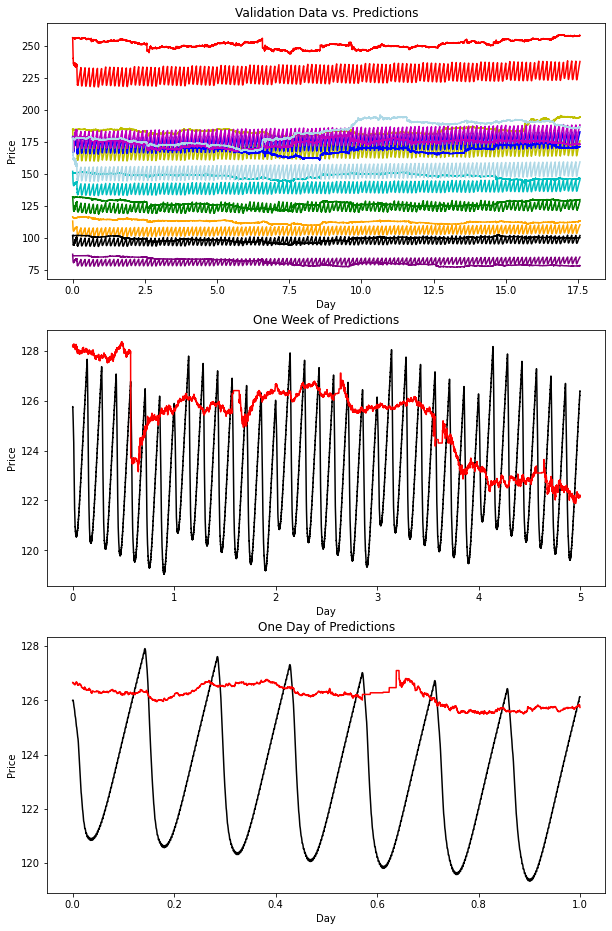

In [ ]:
# Visualizing the predictions
pred_list = np.load('/content/drive/My Drive/val_predictions.npy')
colors = ['c', 'orange', 'k', 'r', 'g', 'y', 'b', 'purple', 'm', 'lightblue']
predictions = np.asarray(pred_list)[1:,:-4]
time = range(predictions.shape[0])
true = np.asarray(test_data)[:,:-4]

day = 5040

# Plotting all
plt.subplots(3,1, figsize=(10,16))
plt.subplot(3,1,1)
plt.title('Validation Data vs. Predictions')
plt.xlabel('Day')
plt.ylabel('Price')
time = np.arange(0, (1+time[-1])/day, 1/day)
for i in range(10):
  plt.plot(time, predictions[:,i], color=colors[i])
  plt.plot(time, true[:,i], color=colors[i])

# Plotting a week
symbol = 4
plt.subplot(3,1,2)
plt.title('One Week of Predictions')
plt.xlabel('Day')
plt.ylabel('Price')
plt.plot(time[:day*5], predictions[day*2:day*7,symbol], colors[2])
plt.plot(time[:day*5], true[day*2:day*7,symbol], colors[3])

# Plotting a day
plt.subplot(3,1,3)
plt.title('One Day of Predictions')
plt.xlabel('Day')
plt.ylabel('Price')
plt.plot(time[:day], predictions[day*4:day*5,symbol], colors[2])
plt.plot(time[:day], true[day*4:day*5,symbol], colors[3])

print()

In [ ]:
# Manual Calculation of Validation MSE
num_days = (1 + pred_list.shape[0])/day
days_p1 = int(np.ceil(num_days/2))
days_p2 = num_days - days_p1

pred = pred_list[1:,:-4]
test = test_targets

# period 1
avg_sums = []
for day_num in range(1,days_p1+1):
  p1_t = test[day*day_num:day*(day_num+1)]
  p1_p = pred[day*day_num:day*(day_num+1)]
  p1_res = np.square(p1_t - p1_p)
  p1_sum = np.sum(np.sum(p1_res))
  p1_avg_sum = p1_sum / day
  avg_sums.append(p1_avg_sum)
p1_mse = np.mean(avg_sums)
print('Period 1 MSE:', np.around(p1_mse, 3))

# period 2
avg_sums = []
for day_num in range(days_p1,int(num_days)+1):
  if day_num == int(num_days):
    p2_t = test[day*day_num:]
    p2_p = pred[day*day_num:]
  else:
    p2_t = test[day*day_num:day*(day_num+1)]
    p2_p = pred[day*day_num:day*(day_num+1)]
  p2_res = np.square(p2_t - p2_p)
  p2_sum = np.sum(np.sum(p1_res))
  p2_avg_sum = p2_sum / day
  avg_sums.append(p2_avg_sum)
p1_mse = np.sum(avg_sums) / days_p2
print('Period 2 MSE:', np.around(p2_mse, 3))

Period 1 MSE: 1811.358
Period 2 MSE: 2492.39


# Refitting and predicting

In [ ]:
# Refitting with validation data
n_input = 12
generator = TimeseriesGenerator(test_data, test_targets, n_input, batch_size=1)
model.fit_generator(generator, epochs=1)
model.save('/content/drive/My Drive/lstm_model_3')

   10/88546 [..............................] - ETA: 8:28 - loss: 7.5594   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


88546/88546 [==============================] - 545s 6ms/step - loss: 0.9099


In [ ]:
 # Generating the predictions for the next 9 days
num_predictions = time_to_idx('06:00:00', 9)
pred_list = test_data[-n_input:]
pred_list = predict(num_predictions, pred_list)
np.save('/content/drive/My Drive/good_predictions', pred_list)

45360
(88558, 14)


100%|██████████| 45360/45360 [36:08<00:00, 20.92it/s]


In [ ]:
# Saving predictions to file in the proper format for Kaggle submission
symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
from tqdm import tqdm

predictions = pd.DataFrame(np.zeros(shape=(num_predictions*10, 2)), columns=['id', 'open'])
datetime = [0, 6, 0, 0]
for i in tqdm(range(len(pred_list))):
  pred = pred_list[i]
  string = time_to_str(datetime)
  for j, symbol in enumerate(symbols):
    id = f'{symbol}-{string}'
    predictions.iloc[i*10 + j,:] = np.append(id, pred[j])
  datetime = next_time(datetime)

predictions.to_csv('/content/drive/My Drive/actual_predictions.csv', index=False)

100%|█████████▉| 45360/45361 [02:56<00:00, 256.85it/s]


IndexError: ignored